![Activation Functions](images/activation.png)

# makemore: part 3 s2, How to solve bad initialization for much complex/deeper NN

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-02-20 03:54:12--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.008s  

2024-02-20 03:54:12 (25.9 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Following Kaiming Init to improve Normalization
1. Not quite important now due to other modern innovated techniques

In [ ]:
emb_size = 10
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, emb_size), generator=g)
## for hidden layer, 100 to 300 neurons to make it more complex
W1 = torch.randn((block_size*emb_size, 200), generator=g) * (5/3) / (emb_size * block_size)**0.5 ##* 0.2 # scale down W1
b1 = torch.randn(200, generator=g) * 0.01 # try to make activations close to zero
W2 = torch.randn((200, 27), generator=g) * 0.01 # scale down W2
b2 = torch.randn(27, generator=g) * 0 # try to make logits close to zero
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad_()

11897


tensor(0.0090) tensor(0.9877)
tensor(0.0003) tensor(0.9984)


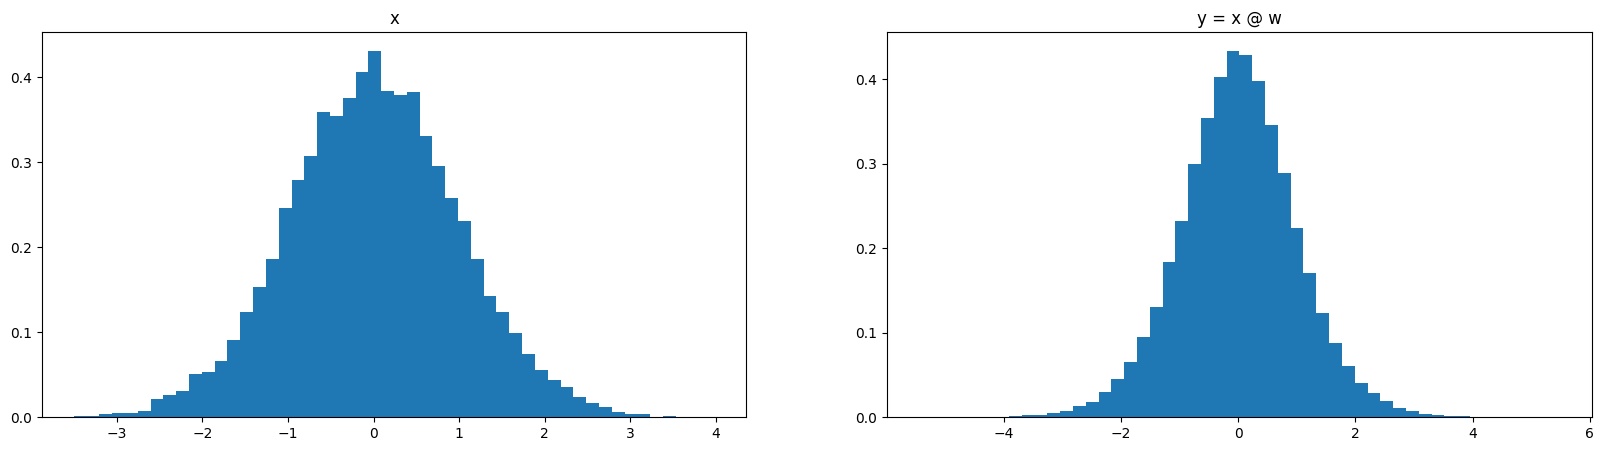

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
# *5 -> more extrem standard deviation
# *0.2 -> 0.6 deviation
y = x @ w # how to scale it to make it preserve the distribution like x sampled from Guassian
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121, title='x')
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122, title='y = x @ w')
plt.hist(y.view(-1).tolist(), bins=50, density=True);


### Initialization Notes
1. [kaiming init 2015](https://arxiv.org/pdf/1502.01852.pdf)
2. [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)

In [ ]:
(torch.randn(10000) * 0.2).std()

tensor(0.1992)

In [ ]:
(5/3) / (emb_size * block_size)**0.5 ## gain / sqrt(fan_in), fan_in = emb_size * block_size

0.3042903097250923

## Batch Normalization
1. [Reducing Internal Covariate Shift 2015](https://arxiv.org/pdf/1502.03167.pdf)

In [8]:
emb_size = 10
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, emb_size),            generator=g)
W1 = torch.randn((emb_size * block_size, n_hidden), generator=g) * (5/3)/((emb_size * block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
## Buffers for batchnorm layer
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C = torch.randn((27, emb_size), generator=g)
# ## for hidden layer, 100 to 300 neurons to make it more complex
# W1 = torch.randn((block_size*emb_size, 200), generator=g) * (5/3) / (emb_size * block_size)**0.5 ##* 0.2 # scale down W1
# b1 = torch.randn(200, generator=g) * 0.01 # try to make activations close to zero
# W2 = torch.randn((200, 27), generator=g) * 0.01 # scale down W2
# b2 = torch.randn(27, generator=g) * 0 # try to make logits close to zero
# parameters = [C, W1, b1, W2, b2]
# print(sum(p.nelement() for p in parameters)) # number of parameters in total
# for p in parameters:
#     p.requires_grad_()

12097


In [9]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear Layer
  hpreact = embcat @ W1# +b1 hidden layer pre-activation
  # BatchNorm layer
  # ----------------------------------------------------
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias# batch normalization
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # ----------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [16]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [17]:
bnmean

tensor([[-2.3148,  0.6874, -0.9136,  0.9966,  1.0880,  1.0840,  1.7472, -2.1107,
          0.5818,  1.4375, -1.6466, -2.7301, -0.4766, -0.1641, -0.0858, -1.1704,
          0.6866, -2.6103, -0.0924,  1.6207, -0.7664, -0.3184,  0.0413,  0.6149,
          1.1046,  0.2279,  2.0388,  0.5843,  0.8446,  1.7754, -0.3646, -0.8379,
         -0.0896, -0.5023, -0.3711, -1.0608, -0.0749,  0.3473, -0.5914,  0.9716,
         -0.4422, -1.3040, -0.3001, -0.2147,  0.6885,  0.6893,  2.0853, -0.7506,
          2.3778,  1.8862,  0.8296,  0.2895,  1.8993,  0.4667,  0.6838, -1.8916,
         -0.0522,  0.4209,  1.3688, -0.9078, -0.4528,  1.1846,  0.5668,  0.6121,
          1.5833,  1.2313, -1.0180,  2.1523, -0.6460,  0.0949, -0.2969, -0.4722,
          0.9620, -1.0408, -2.9998,  0.6501,  1.4310, -0.1545,  0.0938,  0.5273,
          0.2381,  1.2512,  2.0559,  0.6612,  0.0664, -0.0787, -1.6763,  0.2953,
          2.2552, -0.0272, -0.6879,  1.4155, -0.8440, -1.2223, -1.0225,  0.2298,
          0.2183, -0.3140,  

In [15]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9000,  1.0159,  1.0894,  1.0862,  1.7389, -2.1356,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8386,
         -0.0831, -0.5198, -0.3817, -1.0698, -0.0781,  0.3370, -0.5769,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8118,  0.2735,  1.8801,  0.4704,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1070, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2401,  2.0104,  0.6695,  0.0768, -0.0851, -1.6767,  0.2963,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1928, -0.3261,  

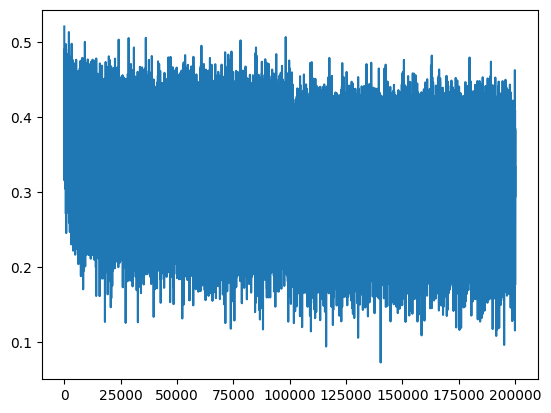

In [ ]:
plt.plot(lossi)

In [18]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # （N, block_size, n_embd）
    embcat = emb.view(emb.shape[0], -1) # concat into ()
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # （N, n_hidden）
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.06659197807312
dev 2.1050572395324707


## loss log

1. orginal loss
    * train 2.1245384216308594
    * val 2.168196439743042

2. after fixing softmax confidently wrong:
    * train 2.07
    * val 2.13

3. after fixing tanh layer too staturated at init
    * train 2.0355966091156006
    * val 2.1026785373687744

4. use semi-principled "kaiming init" instead of hacky init:
    * train 2.0376641750335693
    * val 2.106989622116089

5. add batch norm layer
    * train 2.0668270587921143
    * val 2.104844808578491
